In [1]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Activation function classes
class Sigmoid:
    @staticmethod
    def call(x):
        return 1 / (1 + np.exp(-x))
    @staticmethod
    def derivative(activation):
        return activation * (1 - activation)

class Softmax:
    @staticmethod
    def call(z):
        e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return e_z / np.sum(e_z, axis=1, keepdims=True)

# Loss function class
class CategoricalCrossEntropyLoss:
    @staticmethod
    def loss(y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        loss = -np.sum(y_true * np.log(y_pred_clipped), axis=1)
        return np.mean(loss)
    @staticmethod
    def derivative(y_true, y_pred):
        samples = y_true.shape[0]
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        grad_loss = (y_pred_clipped - y_true) / samples
        return grad_loss

In [3]:
# MLPLayer class represents a single layer in a multi-layer perceptron.
class MLPLayer:
    def __init__(self, input_size, num_units, activation_func):
        # Initialize weights with a small random value to break symmetry.
        self.weights = np.random.normal(0.0, 0.2, (input_size, num_units)).astype(np.float32)
        # Initialize biases to zero since the weight initialization already breaks symmetry.
        self.biases = np.zeros((1, num_units))
        # Store the activation function to be used in the layer.
        self.activation_func = activation_func
        # Placeholders for storing activations during the forward pass.
        self.input_activations = None
        self.pre_activations = None
        self.activation_output = None
        
    def forward(self, input_data):
        # Store the incoming activations.
        self.input_activations = input_data
        # Compute the pre-activation values (weighted sum plus bias).
        self.pre_activations = np.dot(input_data, self.weights) + self.biases
        # Apply the activation function to the pre-activation values.
        self.activation_output = self.activation_func.call(self.pre_activations)
        # Return the post-activation values as output of this layer.
        return self.activation_output
    
    def backward(self, loss_gradient, learning_rate):
        # Backward pass to update the layer's parameters and calculate the gradient for the previous layer.
        if isinstance(self.activation_func, Softmax):
            # The gradient for the output layer (softmax and cross-entropy loss) is simply the difference
            # between the predicted probabilities and the actual labels. (handled by the MLP class)
            activation_gradient = loss_gradient
        else:
            # For hidden layers with other activation functions, the gradient is the product of
            # the derivative of the activation function and the loss gradient.
            activation_gradient = self.activation_func.derivative(self.activation_output) * loss_gradient

        # Calculate the gradient with respect to the weights.
        weights_gradient = np.dot(self.input_activations.T, activation_gradient)

        # Update the weights by subtracting a fraction of the gradient (scaled by the learning rate).
        self.weights -= learning_rate * weights_gradient

        # Calculate the gradient with respect to the biases.
        biases_gradient = np.sum(activation_gradient, axis=0, keepdims=True)

        # Update the biases by subtracting a fraction of the gradient (scaled by the learning rate).
        self.biases -= learning_rate * biases_gradient

        # Calculate the gradient that will be propagated to the previous layer.
        # For layers using softmax, the derivative of the softmax function is accounted for in the loss gradient.
        input_gradient = np.dot(activation_gradient, self.weights.T)

        # Return the gradient with respect to the inputs of this layer.
        return input_gradient

In [4]:
# MLP class representing a multi-layer perceptron neural network.
class MLP:
    def __init__(self, layer_sizes):
        # Initialize the layers of the MLP.
        self.layers = []
        # Loop through each pair of adjacent layer sizes to create the MLP layers.
        for i in range(len(layer_sizes) - 1):
            # Use Sigmoid activation for all but the last layer, which uses Softmax.
            activation = Sigmoid() if i < len(layer_sizes) - 2 else Softmax()
            # Append a new layer to the network with the specified input size, number of neurons (units), and activation function.
            self.layers.append(MLPLayer(layer_sizes[i], layer_sizes[i + 1], activation))

    def forward(self, input_data):
        # Perform a forward pass through the network.
        for layer in self.layers:
            # Pass the input (or the output from the previous layer) through the current layer.
            input_data = layer.forward(input_data)
        # The final output of the network after passing through all layers.
        return input_data
    
    def backward(self, y_true, y_pred, learning_rate=0.01):
        # Compute the derivative of the loss with respect to the predictions (y_pred).
        gradient_loss_to_output = CategoricalCrossEntropyLoss.derivative(y_true, y_pred)
        # Perform a backward pass through the network.
        for layer in reversed(self.layers):
            # Backpropagate the gradient through the current layer.
            gradient_loss_to_output = layer.backward(gradient_loss_to_output, learning_rate)

In [5]:
# Function to train the neural network.
def train_network(network, train_inputs, train_targets, test_inputs, test_targets, epochs, batch_size, learning_rate):
    # Lists to hold loss and accuracy metrics for each epoch.
    train_losses = []
    test_accuracies = []

    # Loop over each epoch.
    for epoch in range(epochs):
        # List to hold losses for each batch in the current epoch.
        batch_loss = []
        # Iterate over batches of data.
        for batch_inputs, batch_targets in batch_generator(train_inputs, train_targets, batch_size):
            # Forward pass: compute the network's predictions for the current batch.
            predictions = network.forward(batch_inputs)
            # Compute the loss for the current batch.
            loss = CategoricalCrossEntropyLoss.loss(predictions, batch_targets)
            # Backward pass: update network weights based on the loss gradient.
            network.backward(batch_targets, predictions, learning_rate)
            # Store the loss for this batch.
            batch_loss.append(loss)

        # Calculate and store the average loss for this epoch.
        avg_loss = np.mean(batch_loss)
        train_losses.append(avg_loss)
        
        # Calculate and store the accuracy on the test set for this epoch.
        test_accuracy = test_network(network, test_inputs, test_targets)
        test_accuracies.append(test_accuracy)
        
        # Output the progress of the training the first and every 50 epochs after.
        if epoch == 0 or (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")
            

    # return train_losses, test_accuracies
    return train_losses, test_accuracies

def test_network(network, test_inputs, test_targets):
    # Perform a forward pass with the test data.
    predictions = network.forward(test_inputs)
    # Convert the probabilities to class predictions by taking the index of the highest probability.
    predicted_classes = np.argmax(predictions, axis=1)
    # Convert one-hot encoded test targets to class indices for comparison.
    true_classes = np.argmax(test_targets, axis=1)
    # Calculate the accuracy as the average number of correct predictions.
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

In [6]:
# Function to plot training loss and test accuracy on the same graph with dual axes.
def plot_training_results(epochs_range, train_losses, test_accuracies):
    # Create a new figure with a single set of axes.
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot training loss on the primary y-axis.
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(epochs_range, train_losses, label='Training Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a secondary y-axis for the test accuracy.
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(epochs_range, test_accuracies, label='Test Accuracy', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title and adjust the layout.
    plt.title('Training Loss and Test Accuracy per Epoch')
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.show()

In [7]:
# Function to split the data into training and test sets based on a specified ratio.
def split_data(inputs, targets, train_ratio=0.8):
    # Determine the size of the training set.
    data_size = len(inputs)
    train_size = int(data_size * train_ratio)
    # Shuffle the data.
    permutation = np.random.permutation(data_size)
    # Split the data into training and test sets.
    return (inputs[permutation][:train_size], targets[permutation][:train_size],
            inputs[permutation][train_size:], targets[permutation][train_size:])

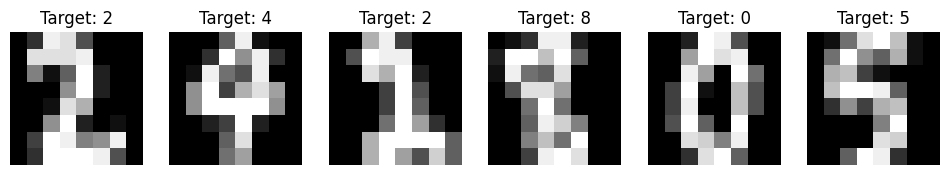

In [8]:
# Load the dataset
digits = load_digits()

# Process the data
n_samples = len(digits.images)
data_images_64 = np.reshape(digits.images, (n_samples, -1))
data_images_64 = (data_images_64 / 16).astype(np.float32)

# One-hot encode the targets
num_classes = 10
identity_matrix = np.eye(num_classes, dtype=np.float32)
one_hot_targets = identity_matrix[digits.target]

# Generator function for batches
def batch_generator(inputs, targets, batch_size=32):
    data_size = len(inputs)
    permutation = np.random.permutation(data_size)
    shuffled_inputs = inputs[permutation]
    shuffled_targets = targets[permutation]
    
    for i in range(0, data_size, batch_size):
        batch_inputs = shuffled_inputs[i:i+batch_size]
        batch_targets = shuffled_targets[i:i+batch_size]
        yield batch_inputs, batch_targets

# plot some images with respective targets to see if the data & batch_generator is correct

# Get the first batch of inputs and targets
batch_inputs, batch_targets = next(batch_generator(data_images_64, one_hot_targets, batch_size=32))

# Plot the first 6 digits with their respective targets
fig, axs = plt.subplots(1, 6, figsize=(12, 4))
for i in range(6):
    axs[i].imshow(batch_inputs[i].reshape(8, 8), cmap='gray')
    axs[i].set_title(f"Target: {np.argmax(batch_targets[i])}")
    axs[i].axis('off')
plt.show()


Epoch 1/500, Loss: 2.4692, Test Accuracy: 15.83%
Epoch 50/500, Loss: 1.0369, Test Accuracy: 86.39%
Epoch 100/500, Loss: 0.4335, Test Accuracy: 90.56%
Epoch 150/500, Loss: 0.2660, Test Accuracy: 94.17%
Epoch 200/500, Loss: 0.1943, Test Accuracy: 95.00%
Epoch 250/500, Loss: 0.1554, Test Accuracy: 95.56%
Epoch 300/500, Loss: 0.1312, Test Accuracy: 96.11%
Epoch 350/500, Loss: 0.1142, Test Accuracy: 96.67%
Epoch 400/500, Loss: 0.1016, Test Accuracy: 97.22%
Epoch 450/500, Loss: 0.0912, Test Accuracy: 96.94%
Epoch 500/500, Loss: 0.0828, Test Accuracy: 96.67%


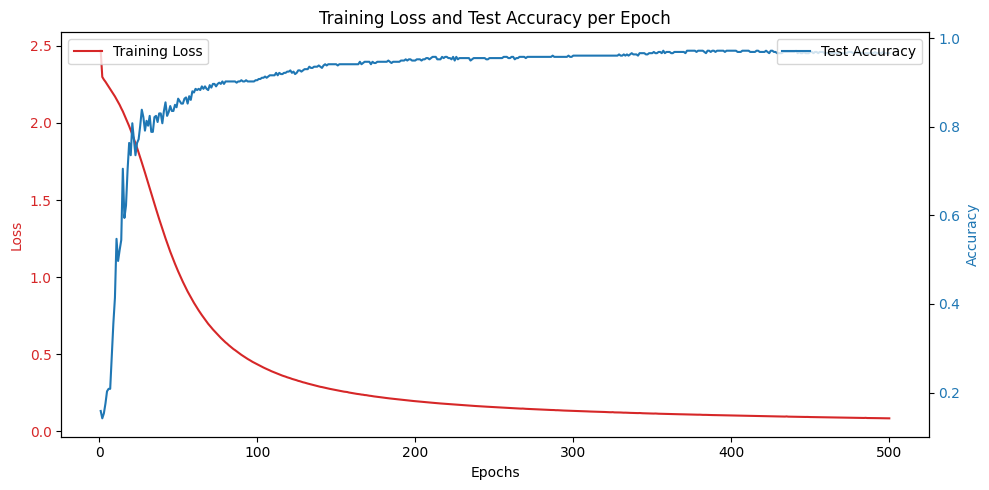

In [9]:
# Main execution flow
# Split the dataset.
train_images, train_targets, test_images, test_targets = split_data(data_images_64, one_hot_targets, train_ratio=0.8)
# define the epochs
epochs = 500

# Initialize the network.
mlp_network = MLP([64, 128, 64, 10])

# Train the network with the specified parameters.
train_losses, test_accuracies = train_network(mlp_network, train_images, train_targets, test_images, test_targets, epochs, batch_size=16, learning_rate=0.01)

# Plot the training results.
plot_training_results(range(1, epochs + 1), train_losses, test_accuracies)

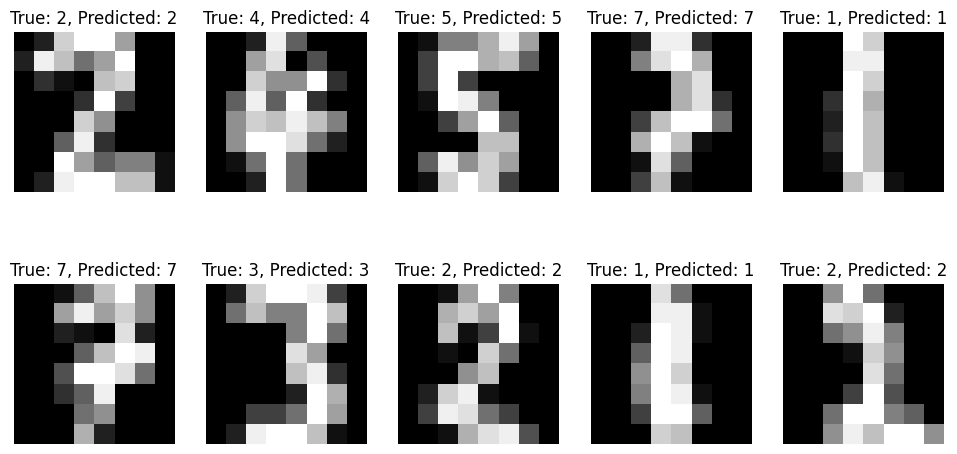

In [12]:
# plot 10 tesing results with their respective targets

# Get the first 10 test inputs and targets
test_inputs, test_targets = test_images[:10], test_targets[:10]

# Get the predicted classes for the test inputs
predictions = mlp_network.forward(test_inputs)
predicted_classes = np.argmax(predictions, axis=1)

# Plot the test inputs with their predicted and true classes
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    axs[i // 5, i % 5].imshow(test_inputs[i].reshape(8, 8), cmap='gray')
    axs[i // 5, i % 5].set_title(f"True: {np.argmax(test_targets[i])}, Predicted: {predicted_classes[i]}")
    axs[i // 5, i % 5].axis('off')
plt.show()
